 # Linear Regression and Seasonality Modeling

 In this script, we will:

 - Fit a **Linear Regression** model to each beam's throughput volume (`thp_vol`) using only **time** as the feature.

 - Calculate the **residuals**, scaled down by the linear predictions.

 - Apply a seasonality model to these residuals using engineered features.

 - Combine the predictions from both models to get the final prediction.



 This method is an example of **Model Stacking** or **Residual Modeling**, where we use one model to capture the main trend and another to model the residuals.

 ## Imports and Setup

In [103]:
# %%
import os
import logging
from pathlib import Path

import numpy as np
import polars as pl
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import wandb
import yaml
import matplotlib.pyplot as plt
import seaborn as sns

# Load utility functions (assuming utils.py is in the same directory)
import utils

# Manually set the notebook name for W&B
os.environ["WANDB_NOTEBOOK_NAME"] = "train_w10_w11.ipynb"

# Set up logging
logging.basicConfig(level=logging.INFO)


 ## Configuration

In [104]:
# %%
# Set DEBUG mode
DEBUG = False

# Load configuration from YAML file
config_file_path = Path('configs') / 'seasonality_config.yaml'
with open(config_file_path, 'r') as file:
    config = yaml.safe_load(file)


 ## Data Loading

In [105]:
# %%
# Read the CSV files
data_dir = Path('input-data')
thp_vol_df = pl.read_csv(data_dir / 'traffic_DLThpVol.csv')
idx_hour_series = thp_vol_df['']
thp_vol_df = thp_vol_df.drop('')

# If in DEBUG mode, shorten dataframes
if DEBUG:
    thp_vol_df = thp_vol_df.head(200).select(thp_vol_df.columns[:800])
    idx_hour_series = idx_hour_series.head(200)


 ## Data Preprocessing

In [106]:
# %%
# Convert idx_hour_series to Polars DataFrame
time_df = pl.DataFrame({'time': idx_hour_series})

# Combine time and thp_vol_df
data_df = pl.concat([time_df, thp_vol_df], how='horizontal')


 ## Initialize W&B

In [107]:
# %%
# Initialize W&B
run = wandb.init(
    project="traffic-forecasting-challenge",
    job_type='train',
    entity="esedx12",
    config=config,
    save_code=True,
    tags=['linear', 'stupid'],
    mode=('disabled' if DEBUG else 'online')
)


 ## Linear Regression Model

In [108]:
# %%
# Split into train and test sets based on time
train_percentage = config['train_percentage']
num_rows = data_df.height
num_train_rows = int(num_rows * train_percentage)

train_df = data_df[:num_train_rows]
test_df = data_df[num_train_rows:]

# Features and targets
X_train_linear = train_df.select(['time'])
Y_train = train_df.drop('time')

X_test_linear = test_df.select(['time'])
Y_test = test_df.drop('time')

# Fit multi-output linear regression
logging.info("Training the multi-output linear regression model...")

# Fit the model
linear_model = LinearRegression()
linear_model.fit(X_train_linear, Y_train)

INFO:root:Training the multi-output linear regression model...


LinearRegression()

In [109]:
long_time = pl.DataFrame({'time': list(range(0, 168 * 11))})
long_time_linear_pred = pl.DataFrame(linear_model.predict(long_time), schema=Y_train.schema)
print(long_time_linear_pred)
# check on what columns there are negatie entries at last row and count them by getting last row and counting negative entries
last_row = list(long_time_linear_pred.row(-1))
num_negatives = sum([1 for i in last_row if i < 0])
print(f"Number of negative entries in last row: {num_negatives}")

shape: (1_848, 2_880)
┌──────────┬──────────┬──────────┬──────────┬───┬──────────┬──────────┬──────────┬──────────┐
│ 0_0_0    ┆ 0_0_1    ┆ 0_0_2    ┆ 0_0_3    ┆ … ┆ 29_2_28  ┆ 29_2_29  ┆ 29_2_30  ┆ 29_2_31  │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞══════════╪══════════╪══════════╪══════════╪═══╪══════════╪══════════╪══════════╪══════════╡
│ 0.400505 ┆ 0.227326 ┆ 0.209757 ┆ 0.067087 ┆ … ┆ 0.059365 ┆ 0.066673 ┆ 0.129431 ┆ 0.102332 │
│ 0.400759 ┆ 0.227318 ┆ 0.209734 ┆ 0.067076 ┆ … ┆ 0.059359 ┆ 0.066714 ┆ 0.129447 ┆ 0.102302 │
│ 0.401012 ┆ 0.227311 ┆ 0.209712 ┆ 0.067066 ┆ … ┆ 0.059353 ┆ 0.066754 ┆ 0.129462 ┆ 0.102272 │
│ 0.401266 ┆ 0.227303 ┆ 0.20969  ┆ 0.067055 ┆ … ┆ 0.059347 ┆ 0.066795 ┆ 0.129477 ┆ 0.102241 │
│ 0.40152  ┆ 0.227295 ┆ 0.209667 ┆ 0.067044 ┆ … ┆ 0.059341 ┆ 0.066835 ┆ 0.129493 ┆ 0.102211 │
│ …        ┆ …        ┆ …        ┆ …  

In [110]:
pre_multipliers = {}
weeks_data = []
for week_idx in range(1, 6):
    week_start = int((week_idx - 1) * 168)
    week_end = int((week_idx * 168))

    pre_multipliers[week_idx] = np.maximum(np.array(long_time_linear_pred)[4 * 168:5 * 168] / np.array(long_time_linear_pred)[week_start:week_end], 0.1)
    pre_multipliers[week_idx] = np.maximum(pre_multipliers[week_idx], 0.1)
    # pre_multipliers[week_idx] = np.expand_dims(pre_multipliers[week_idx], axis=0)
    
    week_data = train_df.drop('time').slice(week_start, 168)

    # print(week_data)
    # print(pre_multipliers[week_idx].shape)

    week_data = week_data.to_numpy() * pre_multipliers[week_idx]
    weeks_data.append(week_data)

In [111]:
logging.info("Calculating seasonality component...")
stacked_5_weeks = np.stack(axis=0, arrays=weeks_data)
stacked_4_weeks = np.stack(axis=0, arrays=weeks_data[1:])
stacked_3_weeks = np.stack(axis=0, arrays=weeks_data[2:])
stacked_2_weeks = np.stack(axis=0, arrays=weeks_data[3:])
# stacked_1_weeks = np.stack(axis=0, arrays=weeks_data[4:])

INFO:root:Calculating seasonality component...


In [112]:
sorted_4_weeks = np.sort(stacked_4_weeks, axis=0)
print(stacked_4_weeks.shape)
seasonality_typical_4_weeks = np.average(sorted_4_weeks, weights=[0.1, 0.35, 0.55, 0], axis=0)

sorted_3_weeks = np.sort(stacked_3_weeks, axis=0)
seasonality_typical_3_weeks = np.average(sorted_3_weeks, weights=[0, 1, 0], axis=0)

sorted_2_weeks = np.sort(stacked_2_weeks, axis=0)
seasonality_typical_2_weeks = np.average(sorted_2_weeks, weights=[0.5, 0.5], axis=0)
seasonality_typical_2_weeks = np.minimum(seasonality_typical_2_weeks, 2 * seasonality_typical_4_weeks)

one_week = weeks_data[4]
seasonality_typical_1_week = np.minimum(one_week, 2 * seasonality_typical_2_weeks)

seasonalities = np.stack((seasonality_typical_4_weeks, seasonality_typical_3_weeks, seasonality_typical_2_weeks, seasonality_typical_1_week), axis=0)
total_seasonality = np.average(seasonalities, axis=0, weights=[1, 1, 1, 1])

(4, 168, 2880)


In [113]:
# # %%
# # Calculate seasonality component by taking the median value of the residuals for each hour across the four weeks
# logging.info("Calculating seasonality component...")

# # Assuming we have 4 weeks of hourly data (4 * 168 rows)
# n_hours_in_week = 168
# num_weeks = 5

# train_df = train_df.drop('time').to_pandas().values.reshape(num_weeks, n_hours_in_week, -1)
# print(train_df.shape)

# # sort every dim 0 series
# train_df = np.sort(train_df, axis=0)

# seasonality_typical = np.average(train_df, weights=[0.1, 0.2, 0.35, 0.35, 0], axis=0)
# seasonality_typical.shape

In [114]:
multipliers = np.maximum(0.8 * np.array(long_time_linear_pred)[5 * 168:6 * 168] / np.array(long_time_linear_pred)[4 * 168:5 * 168], 0.1)
multipliers = np.expand_dims(multipliers, axis=0)

In [115]:
# Multiply each col by its multiplier
seasonality = total_seasonality * multipliers
seasonality = seasonality.squeeze()


In [116]:
seasonality_df = pl.DataFrame(seasonality)
seasonality_df.columns = Y_train.columns

idxs_w10_11 = pl.DataFrame({'idx_hour': list(range(5 * 168, 6 * 168))})

seasonality_df = pl.concat([idxs_w10_11, seasonality_df], how='horizontal')


In [117]:
# pickle and csv
seasonality_df.write_csv('seasonality_final_w5_w6.csv')

In [118]:
# 1. Drop 'time' from 'seasonality_df'
seasonality_df = seasonality_df.drop('idx_hour')


In [119]:
# get the beam ids with largest mean, 4th largest, 16 largest, 64 largest. those are cols in thp_vol_df
means = thp_vol_df.mean()
means.select(pl.all().mean() > 2)

top_ids = thp_vol_df.select(
   col.name for col in 
   thp_vol_df.select(pl.all().mean() > 2) 
   if col.all()
)

beam_id = top_ids.columns[:6]

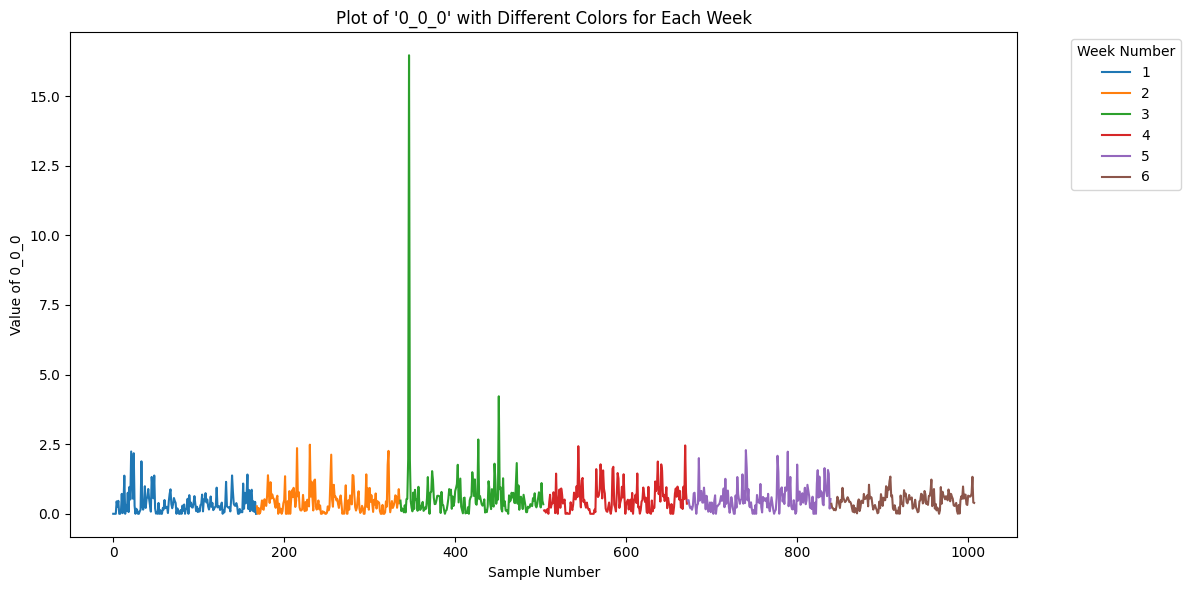

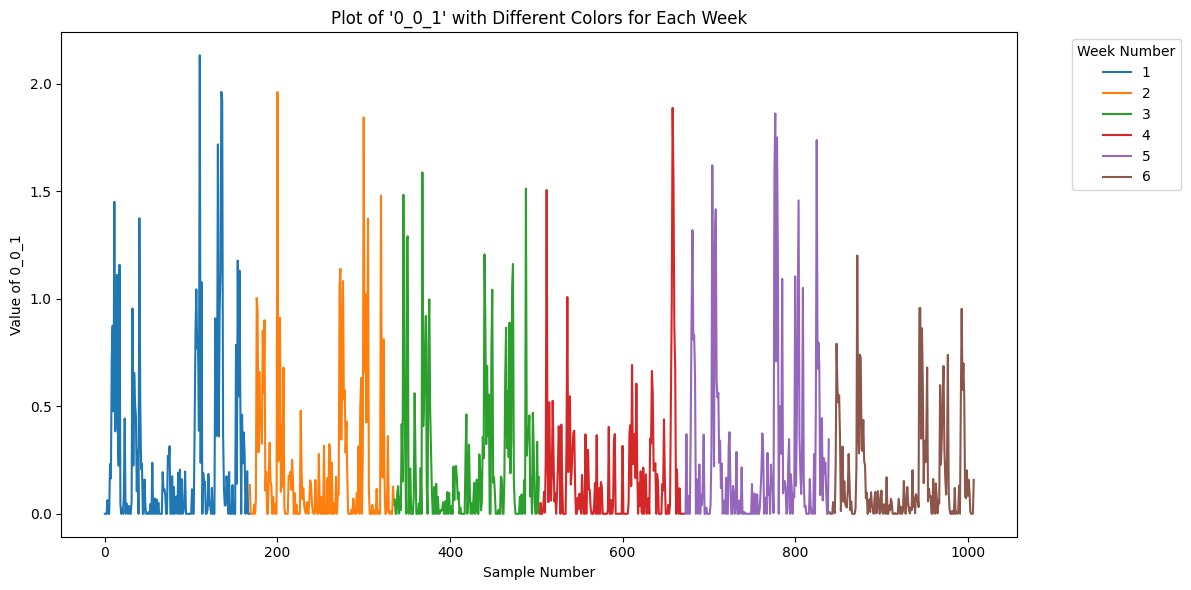

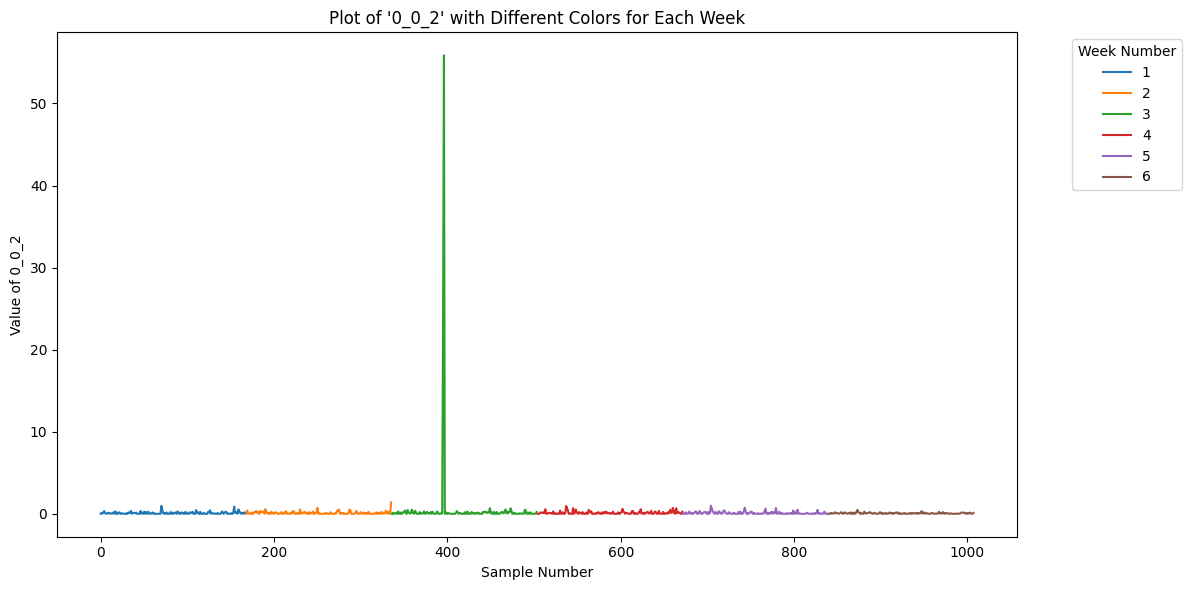

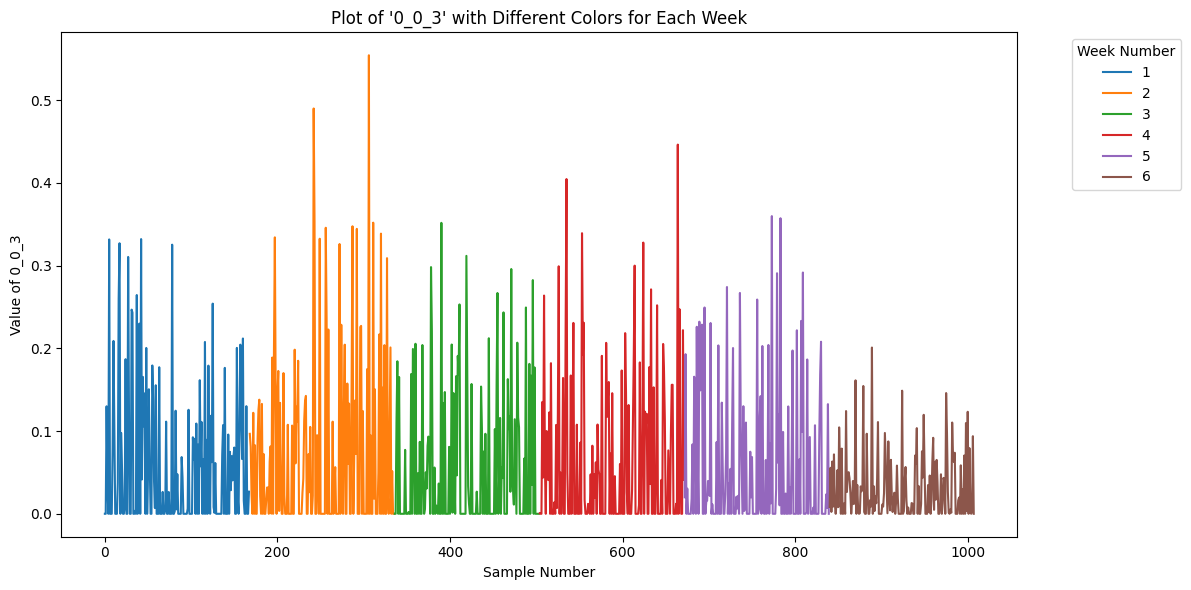

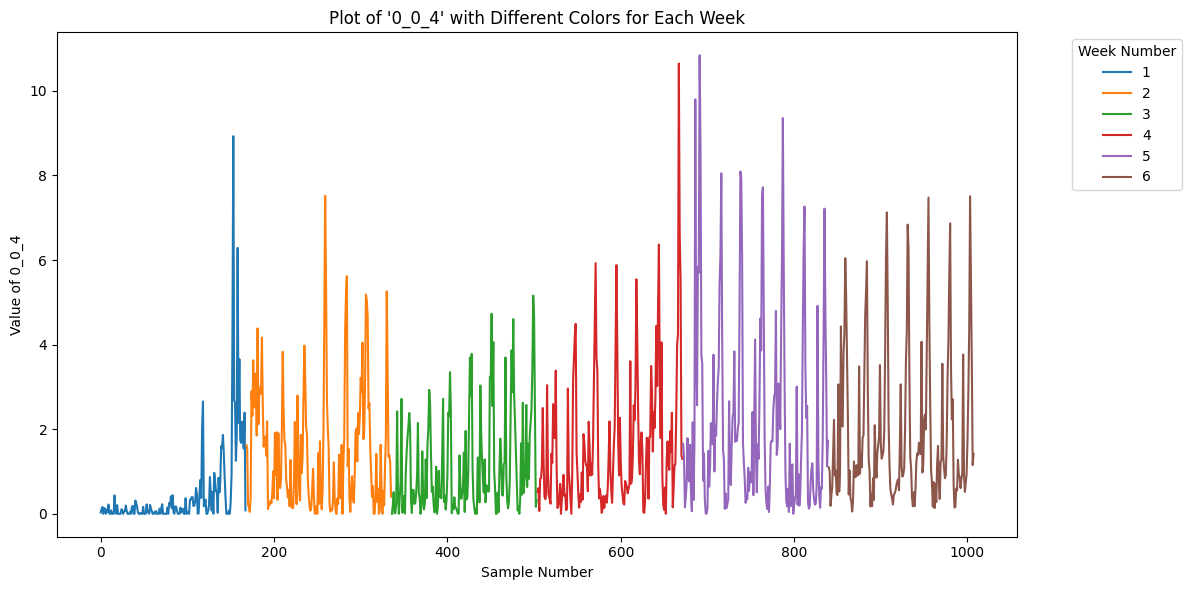

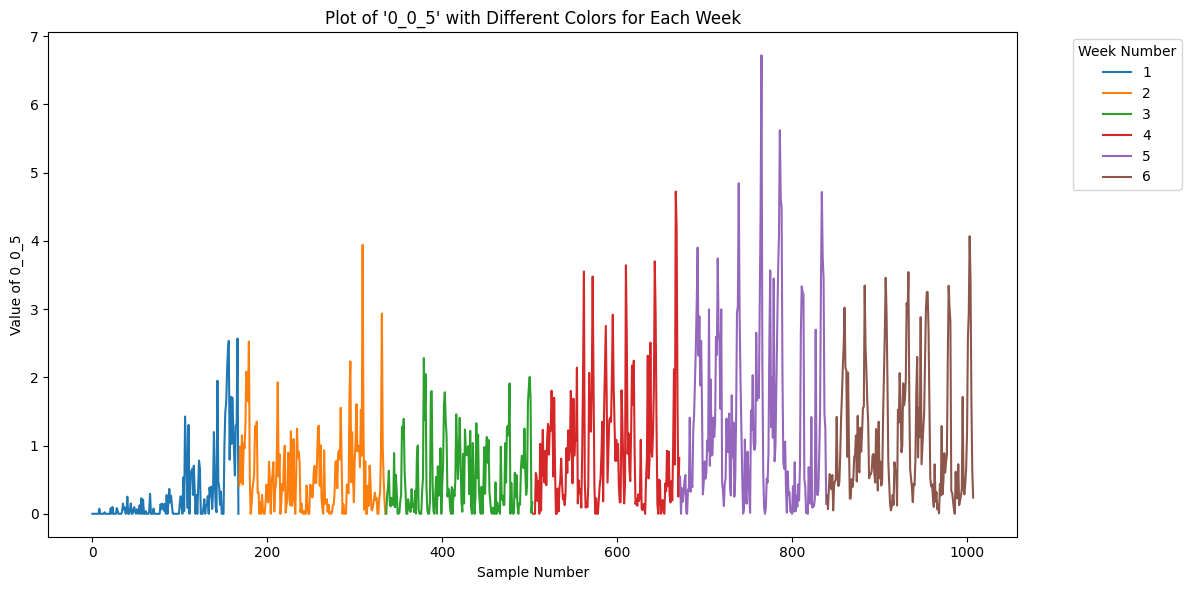

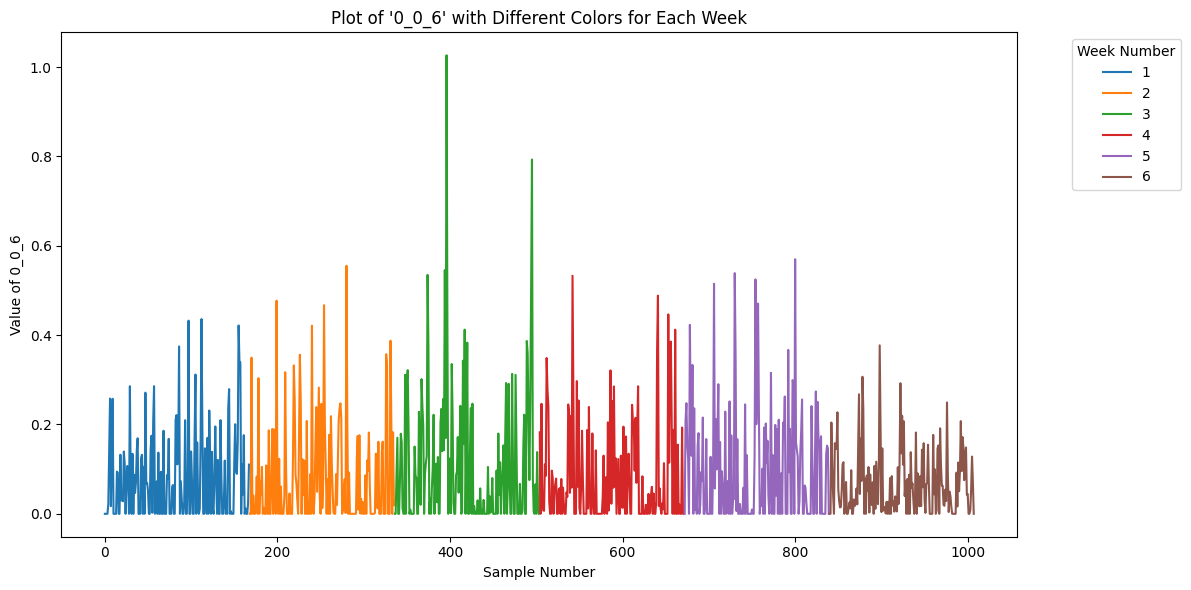

In [120]:
# Concatenate the DataFrames vertically
combined_df = pl.concat([thp_vol_df, seasonality_df], how='vertical')

# Convert to pandas DataFrame for plotting and reset index
combined_df_pd = combined_df.to_pandas().reset_index(drop=True)

# Create a 'week_number' column based on the DataFrame index
combined_df_pd['week_number'] = (combined_df_pd.index // 168) + 1

# Add 'x_axis' column equal to the DataFrame index
combined_df_pd['x_axis'] = combined_df_pd.index

# Define your list of beam IDs
beam_ids = [col for col in combined_df_pd.columns if col not in ['x_axis', 'week_number']]


for beam in beam_ids[:7]:
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=combined_df_pd,
        x='x_axis',
        y=beam,
        hue='week_number',
        palette='tab10'  # Choose a palette that supports multiple colors
    )
    plt.title(f"Plot of '{beam}' with Different Colors for Each Week")
    plt.xlabel('Sample Number')
    plt.ylabel(f'Value of {beam}')
    plt.legend(title='Week Number', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


 ## Evaluation

 ## Finish W&B Run

In [121]:
# %%
wandb.finish()